In [1]:
from pathlib import Path

import pandas as pd

from tqdm import tqdm
import pul_config
import importlib

importlib.reload(pul_config)

import utils

importlib.reload(utils)
from utils import (
    build_proba_df,
    build_ranked_lists,
    load_grid_searches,
    score_df_from_grid_searches,
    train,
)

# CHANGE HERE
input_dirs = [
    Path("1_outputs/standard/"),
    Path("1_outputs/small_DS/"),
    Path("1_outputs/large/"),
    Path("1_outputs/large_small_DS/"),
]
output_dirs = [
    Path("2_outputs/standard/"),
    Path("2_outputs/small_DS/"),
    Path("2_outputs/large/"),
    Path("2_outputs/large_small_DS/"),
]
method = "elkanoto"
pul_cfg = pul_config.ElkanotoConfig

remote_method = "Elkanoto"  # name of the output in S3
# -----

local_method = method
MODEL_NAMES = ("RotatE", "TransE", "CompGCN")
output_dirs = [output_dir / method for output_dir in output_dirs]

## Training

In [ ]:
N_JOBS = 40
CV = 5
rerun = True

for input_dir, output_dir in tqdm(zip(input_dirs, output_dirs), total=len(input_dirs)):
    train(
        input_dir=input_dir,
        output_dir=output_dir,
        model_names=MODEL_NAMES,
        cv=CV,
        n_jobs=N_JOBS,
        pul_cfg=pul_cfg,
        rerun=rerun,
    )

## Evaluation

In [12]:
grid_searches_list = [
    load_grid_searches(output_dir=o, model_names=MODEL_NAMES) for o in output_dirs
]

In [18]:
score_dfs = [
    score_df_from_grid_searches(gs, i) for gs, i in zip(grid_searches_list, input_dirs)
]
for output_dir, score_df in zip(output_dirs, score_dfs):
    score_df.to_csv(output_dir / "score_df.csv")

In [20]:
score_dfs[0].groupby("model_name").mean()

/tmp/ipykernel_3986440/1470429527.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score_dfs[0].groupby('model_name').mean()


,score10_val,score100_val,score10_test,score100_test,score10_all,score100_all,mr_all,mrr_all,amri_all,mr_test,mrr_test,amri_test,tp_test,fp_test,fn_test,tn_test,tp_all,fp_all,fn_all,tn_all
model_name,,,,,,,,,,,,,,,,,,,,
CompGCN,0.9,7.6,0.7,6.5,6.6,37.2,5424.839095,0.005745,0.433364,1375.9904,0.004517,0.279166,797.6,2893.4,7.0,118.0,4149.9,14376.1,16.4,602.6
RotatE,6.3,44.6,7.0,42.5,9.1,80.5,2940.065267,0.009404,0.692952,869.5552,0.027919,0.544663,3603.6,87.4,73.2,51.8,18245.4,280.6,254.9,364.1
TransE,3.5,19.5,3.1,22.4,6.5,43.3,4378.254766,0.005523,0.542702,971.6184,0.014064,0.491157,2148.5,1542.5,31.3,93.7,10933.4,7592.6,133.3,485.7


Text(0, 0.5, 'score')

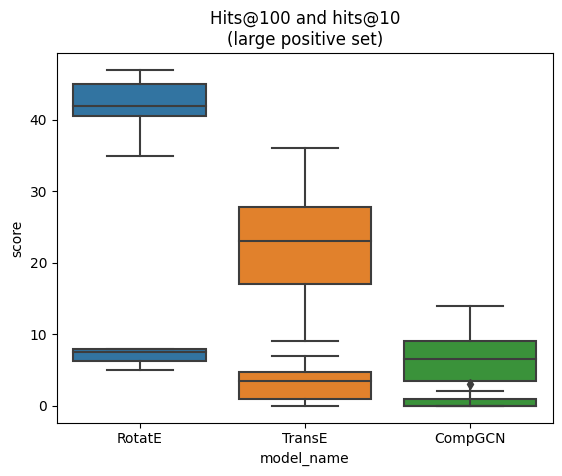

In [21]:
import seaborn as sns

sns.boxplot(score_dfs[0], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set)"
)
sns.boxplot(score_dfs[0], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

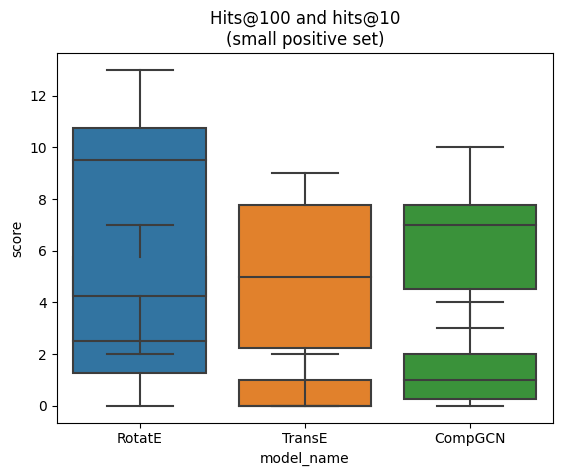

In [22]:
import seaborn as sns

sns.boxplot(score_dfs[1], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(small positive set)"
)
sns.boxplot(score_dfs[1], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

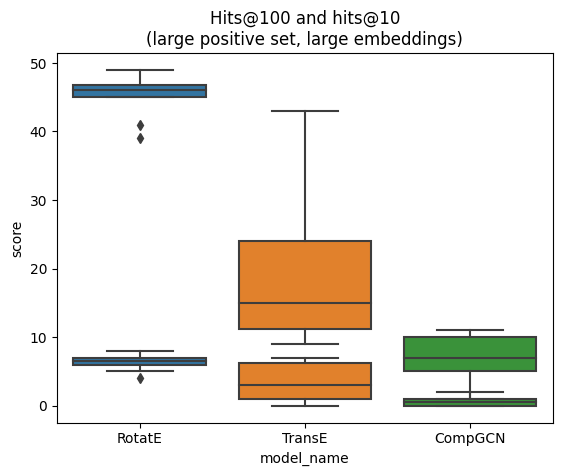

In [23]:
import seaborn as sns

sns.boxplot(score_dfs[2], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set, large embeddings)"
)
sns.boxplot(score_dfs[2], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

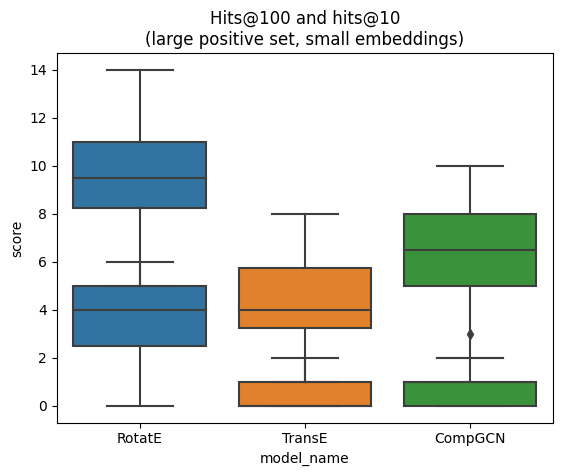

In [24]:
import seaborn as sns

sns.boxplot(score_dfs[3], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set, small embeddings)"
)
sns.boxplot(score_dfs[3], x="model_name", y="score100_test").set_ylabel("score")

In [25]:
score_dfs = []
for output_dir in output_dirs:
    score_dfs.append(pd.read_csv(output_dir / "score_df.csv", index_col=0))
plot_dfs = []
for ds, score_df in zip(
    ("large", "small", "large_embeddings", "large_embeddings_small"), score_dfs
):
    plot_df = score_df[["model_name", "score10_test", "score100_test"]].copy()
    plot_df.columns = ["model_name", "hits@10", "hits@100"]
    plot_df["dataset"] = ds
    plot_dfs.append(plot_df)

plot_df = pd.concat(plot_dfs)
plot_df = plot_df.melt(id_vars=["model_name", "dataset"])
plot_dfs = {k: v for k, v in plot_df.groupby("model_name")}

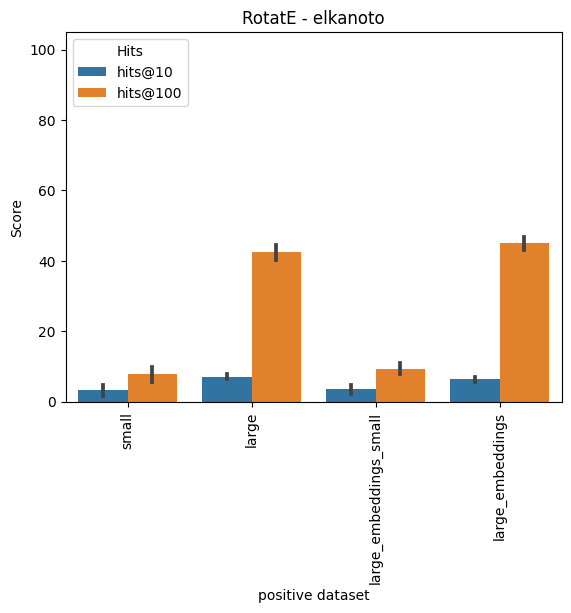

In [30]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "RotatE"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

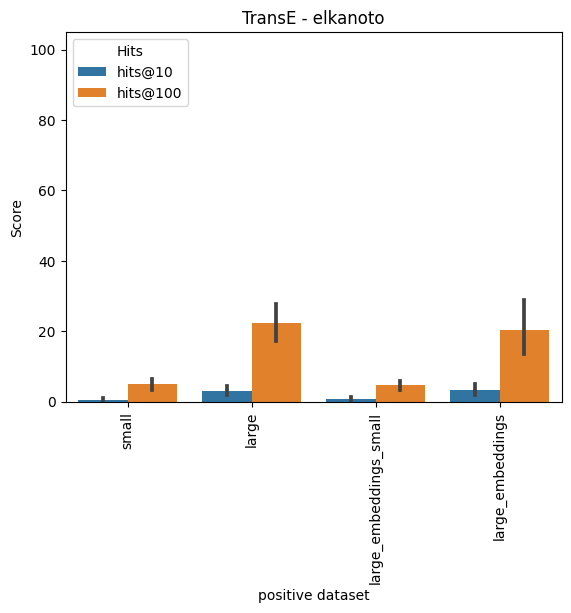

In [31]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "TransE"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

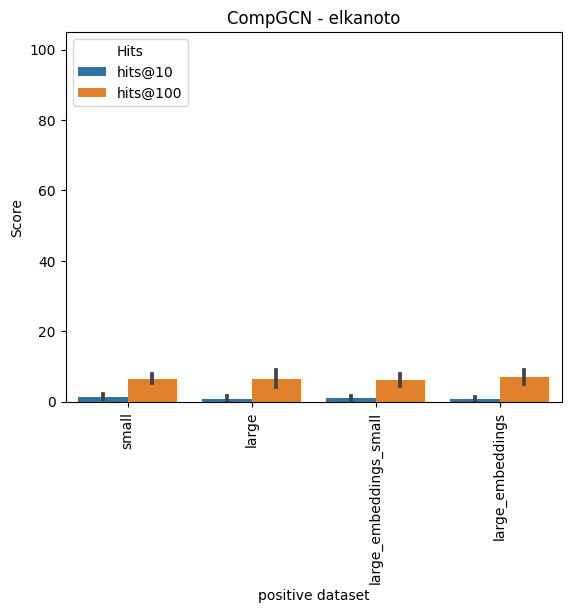

In [32]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "CompGCN"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

In [33]:
proba_dfs = [
    build_proba_df(gs, i, mns=MODEL_NAMES)
    for gs, i in zip(grid_searches_list, input_dirs)
]
for output_dir, proba_df in zip(output_dirs, proba_dfs):
    proba_df.to_csv(output_dir / "proba_df.csv")

In [37]:
proba_df = proba_dfs[0]
proba_df.query("test").sort_values("RotatE_0", ascending=False)

,node_id,gene_name,irr,train,val,test,RotatE_0,RotatE_1,RotatE_2,RotatE_3,...,CompGCN_0,CompGCN_1,CompGCN_2,CompGCN_3,CompGCN_4,CompGCN_5,CompGCN_6,CompGCN_7,CompGCN_8,CompGCN_9
23098,Gene::3643,INSR,True,False,False,True,5.639998,6.150272,5.136619,3.547975,...,1.658597,0.981858,0.419373,1.094261,0.907085,1.216413,1.231097,0.786191,0.844051,1.046252
31154,Gene::811,CALR,False,False,False,True,5.639985,3.554911,4.705466,5.270320,...,1.268709,0.816138,1.164151,0.941765,1.047564,1.264953,0.909140,0.790680,1.332657,1.012311
23819,Gene::3952,LEP,True,False,False,True,5.617531,5.397768,5.087681,6.450837,...,1.091919,1.282714,0.821872,1.487898,1.386015,0.922336,1.261135,0.894026,1.387010,0.720006
23121,Gene::3673,ITGA2,False,False,False,True,5.611691,6.086890,5.262024,6.059140,...,0.879684,0.768095,1.004415,0.812907,0.992248,1.049030,1.037588,0.964820,0.999355,1.087896
18817,Gene::1958,EGR1,True,False,False,True,5.575566,4.290020,0.781585,3.190345,...,0.868617,1.070010,1.026887,1.079120,0.911277,0.552617,0.895998,0.650114,0.839097,1.124372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31139,Gene::810,CALML3,False,False,False,True,0.022254,0.060894,0.081098,0.150301,...,0.971722,0.727844,0.717083,0.091682,0.233291,0.163815,0.803670,0.366848,1.171860,0.974079
20343,Gene::2512,FTL,False,False,False,True,0.021777,0.117979,0.067460,0.042605,...,0.841442,0.802569,1.034061,1.118074,0.987898,1.121807,1.227853,0.865174,1.312929,0.866763
25429,Gene::51499,TRIAP1,False,False,False,True,0.020992,0.029833,0.082284,0.066732,...,0.911392,1.199751,0.717561,1.209424,0.856965,1.113738,1.193154,0.692511,1.014027,0.933932
25409,Gene::51465,UBE2J1,False,False,False,True,0.019427,0.020056,0.061809,0.105849,...,0.873060,0.706047,0.278307,0.792976,0.994979,1.397390,1.062419,0.913004,1.091209,0.927839


In [38]:
for proba_df, score_df, od in zip(proba_dfs, score_dfs, output_dirs):
    proba_df.to_csv(od / "proba_df.csv")
    proba_df.query("test").to_csv(od / "proba_df_test.csv")
    score_df.to_csv(od / "score_df.csv")

    for mn in MODEL_NAMES:
        score_cols = [c for c in proba_df.columns if c.startswith(f"{mn}_")]
        tmp_df = proba_df[
            ["node_id", "gene_name", "irr", "train", "val", "test", *score_cols]
        ]
        tmp_df.to_csv(od / f"proba_df_{mn}.csv")
        tmp_df_test = tmp_df.query("test")
        tmp_df_test.to_csv(od / f"proba_df_test_{mn}.csv")

        genes_100 = build_ranked_lists(tmp_df, prefix=mn)
        genes_100.to_csv(od / f"genes_100_{mn}.csv", index=False)
        genes_100_test = build_ranked_lists(tmp_df_test, prefix=mn)
        genes_100_test.to_csv(od / f"genes_100_test_{mn}.csv", index=False)

        ds = "test"
        score_df_tmp = score_df.query("model_name == @mn")
        score_df_tmp = pd.concat(
            [score_df_tmp["m_name"], score_df_tmp.filter(regex=f".*_{ds}", axis=1)],
            axis=1,
        ).set_index("m_name")
        score_df_tmp.columns = [
            c.replace(f"_{ds}", "").replace("score", "hits@")
            for c in score_df_tmp.columns
        ]
        score_df_tmp = score_df_tmp.T
        score_df_tmp["mean"] = score_df_tmp.mean(axis=1)
        score_df_tmp.to_csv(od / f"scores_{ds}_{mn}.csv", index_label="score")

        ds = "all"
        score_df_tmp = score_df.query("model_name == @mn")
        score_df_tmp = pd.concat(
            [score_df_tmp["m_name"], score_df_tmp.filter(regex=f".*_{ds}", axis=1)],
            axis=1,
        ).set_index("m_name")
        score_df_tmp.columns = [
            c.replace(f"_{ds}", "").replace("score", "hits@")
            for c in score_df_tmp.columns
        ]
        score_df_tmp = score_df_tmp.T
        score_df_tmp["mean"] = score_df_tmp.mean(axis=1)
        score_df_tmp.to_csv(od / f"scores_{mn}.csv", index_label="score")